In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random

# Define dataset root directory
mnist_root = '/home/j597s263/scratch/j597s263/Datasets/MNIST'

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root=mnist_root, transform=transform, train=True, download=False)
test_dataset = datasets.MNIST(root=mnist_root, transform=transform, train=False, download=False)

train_indices = list(range(len(train_dataset)))
random.shuffle(train_indices)  

split_idx = int(0.9 * len(train_indices))  
train_indices, attack_indices = train_indices[:split_idx], train_indices[split_idx:]

train_data = Subset(train_dataset, train_indices)
attack_data = Subset(train_dataset, attack_indices)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Shuffle within batches
attack_loader = DataLoader(attack_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Total training samples: {len(train_dataset)}")
print(f"Training samples after split: {len(train_data)}")
print(f"Attack samples: {len(attack_data)}")
print(f"Testing samples: {len(test_dataset)}")

Total training samples: 60000
Training samples after split: 54000
Attack samples: 6000
Testing samples: 10000


In [2]:
import torch.nn as nn

# Residual block
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

# ConvMixer model with hard-coded parameters
def ConvMixer():
    dim = 256          # Embedding dimension
    depth = 8          # Number of ConvMixer blocks
    kernel_size = 5    # Kernel size for depthwise convolution
    patch_size = 4     # Patch size for initial convolution
    n_classes = 10    # CIFAR-10 has 10 classes

    return nn.Sequential(
        nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for _ in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [3]:
import torch
# Load the entire model
model = torch.load('/home/j597s263/scratch/j597s263/Models/ConvModels/Base/ConvMNIBase.mod', weights_only=False, map_location="cuda:0")

# Move the model to the appropriate device
model = model.to('cuda')

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


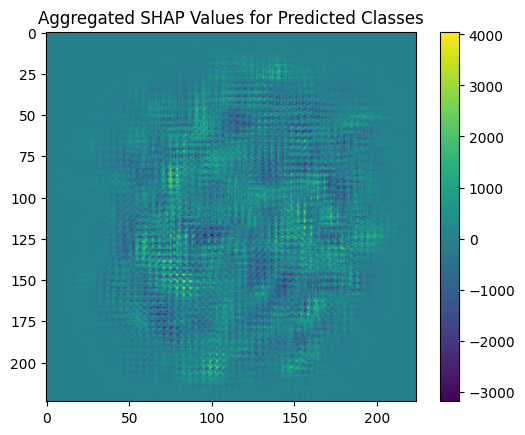

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load SHAP values
file_path = '/home/j597s263/scratch/j597s263/Datasets/Explanation_values/Conv/SHAP_ConvMNI.npy'
shap_values = np.load(file_path)  # Shape: (3, 224, 224, 10)


device = 'cuda'
model.eval()

# Initialize aggregated SHAP array
aggregated_shap_image = np.zeros((224, 224))

# Iterate through the attack_loader to compute predicted classes
for batch_images, _ in attack_loader:
    batch_images = batch_images.to(device)

    # Get model predictions
    outputs = model(batch_images)
    predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()  # Shape: (batch_size,)

    # Compute SHAP values for each image
    for i, predicted_class in enumerate(predicted_classes):
        # Aggregate SHAP values for the predicted class (sum over channels)
        class_shap_values = np.sum(shap_values[:, :, :, predicted_class], axis=0)  # Shape: (224, 224)
        aggregated_shap_image += class_shap_values

# Visualize the aggregated SHAP image
plt.imshow(aggregated_shap_image, cmap="viridis")
plt.title("Aggregated SHAP Values for Predicted Classes")
plt.colorbar()
plt.show()


In [5]:
# Flatten the array and find the indices of the top 22 values
flattened = aggregated_shap_image.flatten()
top_22_indices = np.argsort(flattened)[-22:][::-1]  # Indices of top 22 values, sorted descending

# Convert flattened indices to 2D coordinates
top_22_coords = np.unravel_index(top_22_indices, aggregated_shap_image.shape)
top_22_coords = list(zip(top_22_coords[0], top_22_coords[1]))

# Print the top 22 pixels and their SHAP values
print("Top 22 Pixels and Their SHAP Values:")
for coord in top_22_coords:
    pixel_value = aggregated_shap_image[coord]
    print(f"Pixel {coord}: SHAP Value {pixel_value:.4f}")


Top 22 Pixels and Their SHAP Values:
Pixel (np.int64(151), np.int64(83)): SHAP Value 4052.2726
Pixel (np.int64(155), np.int64(83)): SHAP Value 3719.2752
Pixel (np.int64(147), np.int64(79)): SHAP Value 3648.6408
Pixel (np.int64(87), np.int64(79)): SHAP Value 3611.1268
Pixel (np.int64(151), np.int64(79)): SHAP Value 3597.2382
Pixel (np.int64(151), np.int64(87)): SHAP Value 3534.7593
Pixel (np.int64(155), np.int64(87)): SHAP Value 3349.0364
Pixel (np.int64(139), np.int64(71)): SHAP Value 3281.9125
Pixel (np.int64(139), np.int64(75)): SHAP Value 3262.0433
Pixel (np.int64(91), np.int64(79)): SHAP Value 3260.4550
Pixel (np.int64(147), np.int64(83)): SHAP Value 3238.7741
Pixel (np.int64(143), np.int64(75)): SHAP Value 3198.9313
Pixel (np.int64(89), np.int64(75)): SHAP Value 3184.3026
Pixel (np.int64(83), np.int64(79)): SHAP Value 3129.0567
Pixel (np.int64(147), np.int64(75)): SHAP Value 3078.2211
Pixel (np.int64(108), np.int64(146)): SHAP Value 3055.1810
Pixel (np.int64(115), np.int64(156)): 

In [8]:
ls /home/j597s263/scratch/j597s263/Datasets/Attack/ConvShapMNI

ls: cannot access '/home/j597s263/scratch/j597s263/Datasets/Attack/ConvShapMNI': No such file or directory


In [9]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the directory to save modified images
output_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/ConvShapMNI"
os.makedirs(output_dir, exist_ok=True)

top_22_coords = [
    (151, 83), (155, 83), (147, 79), (87, 79), (151, 79),
    (151, 87), (155, 87), (139, 71), (139, 75), (91, 79),
    (147, 83), (143, 75), (89, 75), (83, 79), (147, 75),
    (108, 146), (115, 156), (167, 158), (85, 75), (155, 79),
    (171, 158), (125, 77)
]

# Transformation to convert tensors back to images
to_pil = transforms.ToPILImage()

# Iterate through attack_loader and modify each image
for idx, (batch_images, _) in enumerate(attack_loader):
    batch_images = batch_images.clone()  # Clone to avoid modifying the original dataset

    for img_idx, image_tensor in enumerate(batch_images):
        # Replace top pixel locations with black (0 value for all channels)
        for x, y in top_22_coords:
            image_tensor[:, x, y] = 0  # Set RGB channels to 0 at the specified location

        # Convert tensor to PIL image and save
        pil_image = to_pil(image_tensor)
        output_path = os.path.join(output_dir, f"image_{idx * len(batch_images) + img_idx}.png")
        pil_image.save(output_path)

    print(f"Processed batch {idx+1}/{len(attack_loader)}")

print(f"Modified images saved to {output_dir}")


Processed batch 1/94
Processed batch 2/94
Processed batch 3/94
Processed batch 4/94
Processed batch 5/94
Processed batch 6/94
Processed batch 7/94
Processed batch 8/94
Processed batch 9/94
Processed batch 10/94
Processed batch 11/94
Processed batch 12/94
Processed batch 13/94
Processed batch 14/94
Processed batch 15/94
Processed batch 16/94
Processed batch 17/94
Processed batch 18/94
Processed batch 19/94
Processed batch 20/94
Processed batch 21/94
Processed batch 22/94
Processed batch 23/94
Processed batch 24/94
Processed batch 25/94
Processed batch 26/94
Processed batch 27/94
Processed batch 28/94
Processed batch 29/94
Processed batch 30/94
Processed batch 31/94
Processed batch 32/94
Processed batch 33/94
Processed batch 34/94
Processed batch 35/94
Processed batch 36/94
Processed batch 37/94
Processed batch 38/94
Processed batch 39/94
Processed batch 40/94
Processed batch 41/94
Processed batch 42/94
Processed batch 43/94
Processed batch 44/94
Processed batch 45/94
Processed batch 46/